In [4]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [5]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
... resuming from 1064304640 bytes (78587054 bytes left) ...
100% 1.06G/1.06G [00:02<00:00, 43.8MB/s]
100% 1.06G/1.06G [00:02<00:00, 32.7MB/s]


In [6]:
import zipfile
zip = zipfile.ZipFile('/content/dogs-vs-cats.zip' , 'r')
zip.extractall('/content/')
zip.close()

In [20]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense , Conv2D , Flatten, MaxPool2D, Dropout, BatchNormalization

# Generators

In [51]:
train_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/train',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256 , 256)
)


test_data = tf.keras.utils.image_dataset_from_directory(
    directory = '/content/test',
    labels = 'inferred',
    label_mode = 'int',
    batch_size = 32,
    image_size = (256 , 256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


**`inferred`: This tells TensorFlow to infer the labels automatically based on the folder structure. The dataset directory ('/content/train') is expected to contain subdirectories where each subdirectory name represents a class label. TensorFlow will assign labels to the images based on the name of the subdirectory in which they are located.**

In [52]:
train_data.class_names

['cats', 'dogs']

# to view inside train_data (generator)

In [53]:
for images, labels in train_data.take(1):  # Take 1 batch of data
    print("Images shape:", images.shape)  # Shape of the batch of images
    print("Labels shape:", labels.shape)  # Shape of the corresponding labels
    print("First image:\n", images[0].numpy())  # First image in the batch
    print("First label:\n", labels[0].numpy())  # Label for the first image

Images shape: (32, 256, 256, 3)
Labels shape: (32,)
First image:
 [[[68.70703  57.70703  39.70703 ]
  [71.84766  60.847656 42.847656]
  [73.       62.       44.      ]
  ...
  [72.75119  54.751186 32.751186]
  [73.384766 55.384766 32.23242 ]
  [73.70703  55.70703  31.707031]]

 [[69.84094  58.840946 40.840946]
  [72.249405 61.2494   43.2494  ]
  [73.       62.       44.      ]
  ...
  [75.39453  57.39453  35.39453 ]
  [75.84239  57.842396 34.690052]
  [75.53821  57.53821  33.53821 ]]

 [[71.16211  60.16211  41.83789 ]
  [72.       61.       42.67578 ]
  [73.       62.       43.67578 ]
  ...
  [78.32422  60.32422  38.32422 ]
  [78.23082  60.230816 37.078472]
  [78.16211  60.16211  36.16211 ]]

 ...

 [[96.63672  86.63672  74.63672 ]
  [99.06871  89.06871  77.06871 ]
  [98.31438  88.31438  76.31438 ]
  ...
  [90.474686 78.474686 64.474686]
  [90.73828  78.73828  65.890625]
  [91.602325 79.602325 67.602325]]

 [[96.171875 86.171875 74.171875]
  [98.29552  88.29552  76.29552 ]
  [97.51402 

## Normalizing the dataset

In [54]:
def process(image , label):
  image = tf.cast(image / 255 , tf.float32) # MinMaxScaling with type casting into float32
  return image , label

train_data = train_data.map(process)
test_data = test_data.map(process)

In [101]:
model = Sequential ()

model.add(Conv2D(32 ,kernel_size = (3,3), padding = 'valid' , activation = 'relu' , input_shape = (256, 256 ,3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2) ,strides = 2, padding = 'valid'  ))

model.add(Conv2D(64 ,kernel_size = (3,3), padding = 'valid' , activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2) ,strides = 2, padding = 'valid'  ))

model.add(Conv2D(128 ,kernel_size = (3,3), padding = 'valid' , activation = 'relu' ))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2,2) ,strides = 2, padding = 'valid'  ))

model.add(Flatten())

model.add(Dense(128, activation = 'relu' ))
model.add(Dropout(0.2))
model.add(Dense(64, activation = 'relu' ))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid' ))

In [102]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [103]:
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

**The dataset `train_data` should be converted into a NumPy array, with the features (images) stored in `x_train` and the labels stored in `y_train`, while maintaining a batch size of 32.**

In [104]:
history = model.fit(train_data , epochs = 10 , validation_data = test_data)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 61s 87ms/step - accuracy: 0.5341 - loss: 2.8420 - val_accuracy: 0.5756 - val_loss: 1.0651
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 82ms/step - accuracy: 0.5915 - loss: 0.6896 - val_accuracy: 0.5792 - val_loss: 0.6884
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.6304 - loss: 0.6777 - val_accuracy: 0.6660 - val_loss: 0.6047
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 82ms/step - accuracy: 0.7041 - loss: 0.5781 - val_accuracy: 0.6818 - val_loss: 0.5795
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.7545 - loss: 0.5089 - val_accuracy: 0.6266 - val_loss: 0.7202
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 79s 81ms/step - accuracy: 0.7771 - loss: 0.4712 - val_accuracy: 0.7734 - val_loss: 0.4793
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.8111 - loss: 0.4141 - val_accuracy: 0.7658 - val_loss: 0.4964
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.8489 - loss: 0.3596 - 

In [105]:
model.evaluate(test_data)

157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - accuracy: 0.8148 - loss: 0.6529


[0.6587700247764587, 0.8162000179290771]

above testing loss and accuracy

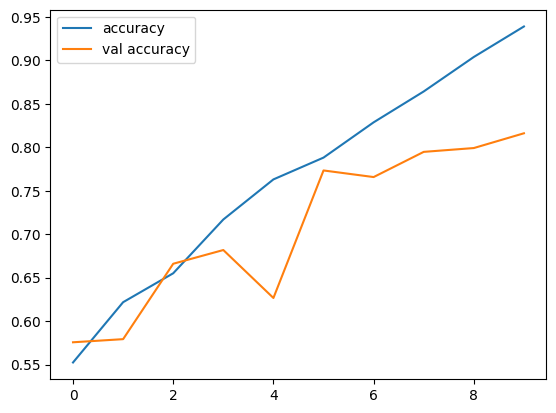

In [106]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'] , label = 'accuracy')
plt.plot(history.history['val_accuracy'] , label = 'val accuracy')
plt.legend()

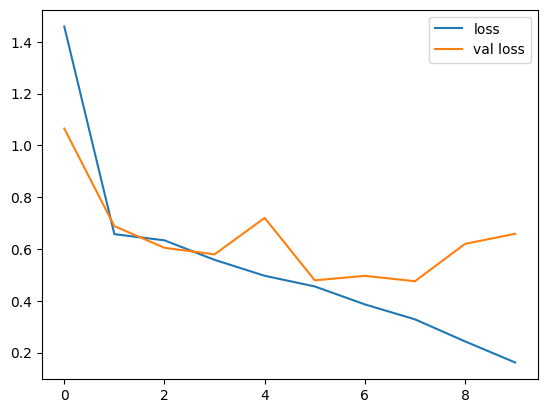

In [107]:
plt.plot(history.history['loss'] , label = 'loss')
plt.plot(history.history['val_loss'] , label = 'val loss')
plt.legend()

# testing on Images

In [108]:
import cv2

In [109]:
dog = cv2.imread('/content/dog.jfif')
dog_2 = cv2.imread('/content/dog 2.jfif')
cat = cv2.imread('/content/cat.jfif')
cat_2 = cv2.imread('/content/cat 2.jfif')

array([[[242, 242, 242],
        [236, 236, 236],
        [232, 232, 232],
        ...,
        [239, 239, 239],
        [242, 242, 242],
        [245, 245, 245]],

       [[242, 242, 242],
        [238, 238, 238],
        [234, 234, 234],
        ...,
        [237, 237, 237],
        [240, 240, 240],
        [243, 243, 243]],

       [[238, 238, 238],
        [237, 237, 237],
        [236, 236, 236],
        ...,
        [236, 236, 236],
        [239, 239, 239],
        [242, 242, 242]],

       ...,

       [[234, 234, 234],
        [238, 238, 238],
        [238, 238, 238],
        ...,
        [240, 240, 240],
        [242, 242, 242],
        [244, 244, 244]],

       [[238, 238, 238],
        [241, 241, 241],
        [242, 242, 242],
        ...,
        [244, 244, 244],
        [245, 245, 245],
        [246, 246, 246]],

       [[246, 246, 246],
        [249, 249, 249],
        [248, 248, 248],
        ...,
        [247, 247, 247],
        [247, 247, 247],
        [247, 247, 247]]], dtype=uint8)
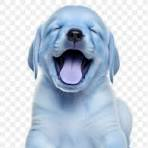

In [110]:
dog

array([[[247, 255, 250],
        [247, 255, 250],
        [250, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[247, 255, 250],
        [249, 255, 251],
        [250, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[249, 255, 251],
        [249, 255, 251],
        [250, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [243, 250, 253],
        [250, 255, 255],
        [240, 245, 244]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [242, 249, 252],
        [250, 255, 255],
        [244, 249, 248]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [241, 248, 251],
        [250, 255, 255],
        [248, 253, 252]]], dtype=uint8)
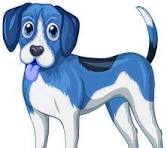

In [111]:
dog_2

array([[[132, 178, 189],
        [132, 178, 189],
        [133, 179, 190],
        ...,
        [ 33,  37,  42],
        [ 34,  38,  43],
        [ 36,  39,  44]],

       [[131, 177, 188],
        [132, 178, 189],
        [133, 179, 190],
        ...,
        [ 28,  34,  39],
        [ 29,  35,  40],
        [ 31,  35,  40]],

       [[131, 177, 188],
        [132, 178, 189],
        [132, 178, 189],
        ...,
        [ 27,  35,  42],
        [ 27,  35,  42],
        [ 29,  35,  42]],

       ...,

       [[139, 144, 153],
        [143, 150, 159],
        [149, 158, 168],
        ...,
        [190, 182, 183],
        [190, 182, 182],
        [190, 183, 180]],

       [[141, 146, 155],
        [154, 161, 170],
        [168, 177, 187],
        ...,
        [199, 191, 192],
        [199, 191, 191],
        [199, 192, 189]],

       [[151, 156, 165],
        [165, 172, 181],
        [179, 188, 198],
        ...,
        [155, 147, 148],
        [155, 147, 147],
        [155, 148, 145]]], dtype=uint8)
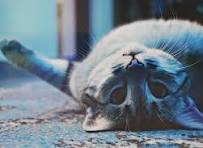

In [112]:
cat

array([[[ 64,  70,  75],
        [ 88,  94,  99],
        [138, 144, 149],
        ...,
        [249, 251, 252],
        [241, 243, 244],
        [237, 239, 240]],

       [[107, 113, 118],
        [ 98, 104, 109],
        [ 91,  97, 102],
        ...,
        [233, 237, 238],
        [229, 231, 232],
        [220, 224, 225]],

       [[137, 143, 148],
        [137, 143, 148],
        [ 64,  70,  75],
        ...,
        [226, 231, 232],
        [226, 230, 231],
        [217, 222, 223]],

       ...,

       [[106, 112, 119],
        [111, 117, 124],
        [112, 118, 125],
        ...,
        [212, 218, 223],
        [138, 144, 149],
        [ 47,  53,  58]],

       [[ 85,  91,  98],
        [ 83,  89,  96],
        [ 78,  84,  91],
        ...,
        [140, 146, 151],
        [161, 167, 172],
        [148, 154, 159]],

       [[ 68,  74,  81],
        [ 65,  71,  78],
        [ 62,  68,  75],
        ...,
        [ 34,  40,  45],
        [ 87,  93,  98],
        [181, 187, 192]]], dtype=uint8)
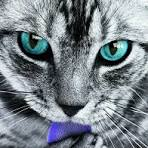

In [113]:
cat_2

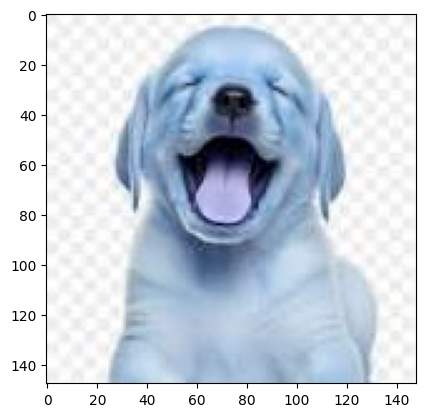

In [114]:
plt.imshow(dog)

array([[[242, 242, 242],
        [240, 240, 240],
        [236, 236, 236],
        ...,
        [242, 242, 242],
        [244, 244, 244],
        [245, 245, 245]],

       [[242, 242, 242],
        [240, 240, 240],
        [237, 237, 237],
        ...,
        [241, 241, 241],
        [243, 243, 243],
        [244, 244, 244]],

       [[242, 242, 242],
        [240, 240, 240],
        [238, 238, 238],
        ...,
        [240, 240, 240],
        [242, 242, 242],
        [243, 243, 243]],

       ...,

       [[238, 238, 238],
        [240, 240, 240],
        [241, 241, 241],
        ...,
        [245, 245, 245],
        [246, 246, 246],
        [246, 246, 246]],

       [[243, 243, 243],
        [244, 244, 244],
        [246, 246, 246],
        ...,
        [246, 246, 246],
        [246, 246, 246],
        [247, 247, 247]],

       [[246, 246, 246],
        [247, 247, 247],
        [249, 249, 249],
        ...,
        [247, 247, 247],
        [247, 247, 247],
        [247, 247, 247]]], dtype=uint8)
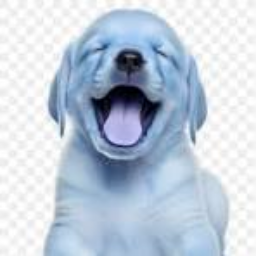

In [115]:
# converting into 256, 256
cv2.resize(dog , (256,256))

In [116]:
dog = cv2.resize(dog , (256,256))
dog_2 = cv2.resize(dog_2 , (256,256))
cat = cv2.resize(cat , (256,256))
cat_2 = cv2.resize(cat_2 , (256,256))

array([[[ 64,  70,  75],
        [ 73,  79,  84],
        [ 87,  93,  98],
        ...,
        [241, 243, 244],
        [238, 240, 241],
        [237, 239, 240]],

       [[ 80,  86,  91],
        [ 84,  90,  95],
        [ 91,  97, 102],
        ...,
        [236, 238, 239],
        [233, 235, 236],
        [231, 233, 234]],

       [[105, 111, 116],
        [102, 108, 113],
        [ 98, 104, 109],
        ...,
        [229, 231, 232],
        [224, 227, 228],
        [221, 225, 226]],

       ...,

       [[ 84,  90,  97],
        [ 83,  89,  96],
        [ 82,  88,  95],
        ...,
        [157, 162, 167],
        [152, 158, 163],
        [150, 156, 161]],

       [[ 74,  80,  87],
        [ 73,  79,  86],
        [ 72,  78,  85],
        ...,
        [117, 123, 128],
        [149, 155, 160],
        [169, 175, 180]],

       [[ 68,  74,  81],
        [ 67,  73,  80],
        [ 65,  71,  78],
        ...,
        [ 92,  98, 103],
        [146, 152, 157],
        [181, 187, 192]]], dtype=uint8)
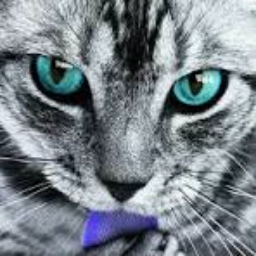

In [117]:
cat_2

In [118]:
# now reshape it into 1 , 256 , 256 , 3 for prediction

dog_input = dog.reshape((1,256,256,3))
dog_2_input = dog_2.reshape((1,256,256,3))
cat_input = cat.reshape((1,256,256,3))
cat_2_input = cat_2.reshape((1,256,256,3))

In [119]:
dog_input

array([[[[242, 242, 242],
         [240, 240, 240],
         [236, 236, 236],
         ...,
         [242, 242, 242],
         [244, 244, 244],
         [245, 245, 245]],

        [[242, 242, 242],
         [240, 240, 240],
         [237, 237, 237],
         ...,
         [241, 241, 241],
         [243, 243, 243],
         [244, 244, 244]],

        [[242, 242, 242],
         [240, 240, 240],
         [238, 238, 238],
         ...,
         [240, 240, 240],
         [242, 242, 242],
         [243, 243, 243]],

        ...,

        [[238, 238, 238],
         [240, 240, 240],
         [241, 241, 241],
         ...,
         [245, 245, 245],
         [246, 246, 246],
         [246, 246, 246]],

        [[243, 243, 243],
         [244, 244, 244],
         [246, 246, 246],
         ...,
         [246, 246, 246],
         [246, 246, 246],
         [247, 247, 247]],

        [[246, 246, 246],
         [247, 247, 247],
         [249, 249, 249],
         ...,
         [247, 247, 247],
        

cat ---> 0 and dog ----> 1

In [127]:
import numpy as np
np.where (model.predict(dog_input) > 0.5 , 'dog', 'cat')[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'cat'

In [129]:
np.where (model.predict(dog_2_input) > 0.5 , 'dog', 'cat')[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'cat'

In [130]:
np.where (model.predict(cat_input) > 0.5 , 'dog', 'cat')[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


'cat'

In [131]:
np.where (model.predict(cat_2_input) > 0.5 , 'dog', 'cat')[0][0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


'cat'